In [1]:
Project = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Projects/Adipocyte'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.rcParams.update(plt.rcParamsDefault)

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

plt.rcParams['ps.useafm']=True
plt.rcParams['pdf.fonttype']=42

plt.rc('font', size=7)          # controls default text sizes
plt.rc('axes', titlesize=7)     # fontsize of the axes title
plt.rc('axes', labelsize=7)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
plt.rc('legend', fontsize=6)    # legend fontsize
suptitlesize = 7

plt.rc('axes', axisbelow=True) #push axes to back
mpl.rcParams['axes.linewidth'] = 0.5
# plt.rcParams['axes.facecolor']='#E7E8E9'

---

In [2]:
MitoCarta3_file = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Data_Library/MITOCARTA3.0/Mouse.MitoCarta3.0.xls'
MitoCarta = pd.read_excel(MitoCarta3_file, 'A Mouse MitoCarta3.0')
MitoPW    = pd.read_excel(MitoCarta3_file, 'C MitoPathways')

name2ID = MitoCarta[['Symbol','EnsemblGeneID']].set_index('Symbol')['EnsemblGeneID'].to_dict()

MitoPW['PW level'] = MitoPW['MitoPathway Hierarchy'].str.split('>').str.len()
MitoPW['gene_ids'] = ''
for i in range(len(MitoPW)):
    for gene in MitoPW.iloc[i,:]['Genes'].split(', '):
        if type(name2ID[gene]) == float : continue
        MitoPW['gene_ids'][i] += name2ID[gene].replace('|',',') + ','
    MitoPW['gene_ids'][i] = MitoPW['gene_ids'][i][:-1]
MitoPW = MitoPW.set_index('MitoPathway',drop=True)

/var/folders/ct/z73cq4_j2g5612tltg_pmxxc0000gn/T/ipykernel_38318/3320499072.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MitoPW['gene_ids'][i] += name2ID[gene].replace('|',',') + ','
/var/folders/ct/z73cq4_j2g5612tltg_pmxxc0000gn/T/ipykernel_38318/3320499072.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MitoPW['gene_ids'][i] = MitoPW['gene_ids'][i][:-1]


In [3]:
Genesets = {
    'Mitochondrial ribosome' : pd.DataFrame({'gene_id' : MitoPW.loc['Mitochondrial ribosome','gene_ids'].split(',')}),
    'Mitochondrial ribosome assembly' : pd.DataFrame({'gene_id' : MitoPW.loc['Mitochondrial ribosome assembly','gene_ids'].split(',')}),
    # 'Translation factors' : pd.DataFrame({'gene_id' : MitoPW.loc['Translation factors','gene_ids'].split(',')}),
    'mt-rRNA modifications' : pd.DataFrame({'gene_id' : MitoPW.loc['mt-rRNA modifications','gene_ids'].split(',')}),
    'mt-tRNA modifications' : pd.DataFrame({'gene_id' : MitoPW.loc['mt-tRNA modifications','gene_ids'].split(',')}),
    'mt-tRNA synthetases' : pd.DataFrame({'gene_id' : MitoPW.loc['mt-tRNA synthetases','gene_ids'].split(',')}),
    'All MitoCarta' : MitoCarta[['EnsemblGeneID']].drop_duplicates().rename(columns={'EnsemblGeneID':'gene_id'}),
    'TCA cycle' : pd.DataFrame({'gene_id' : MitoPW.loc['TCA cycle','gene_ids'].split(',')}),
    'Fatty acid oxidation' : pd.DataFrame({'gene_id' : MitoPW.loc['Fatty acid oxidation','gene_ids'].split(',')}),
}

In [4]:
def strip_plot(x, y, width, s, c, lw, ax, rasterized):
    ax.scatter(list( x + (np.random.rand(1,len(y))[0] -0.5) * width ), y, 
                s=s, c=c, lw=lw,
                rasterized = rasterized,
                zorder=5)

---

In [5]:
RNA = pd.read_csv(f'{Project}/Results/Tables/CPM_RD_calculation/v20221217/adi_RNA_avg_log2FC.tsv', sep='\t').drop(columns='gene_name')
RPF = pd.read_csv(f'{Project}/Results/Tables/CPM_RD_calculation/v20221217/adi_RPF_avg_log2FC.tsv', sep='\t').drop(columns='gene_name')
# PT = pd.read_csv(f'{Project}/Results/Tables/Proteome/PT_Norm_FC_calculation/v20230104/adi_PT_avg_log2FC.tsv', sep='\t')
# PT_conv = pd.read_csv(f'{Project}/Results/Tables/Proteome/adi_proteome_logExp_geneid.tsv', sep='\t', usecols=('uniprot_id','gene_id'))
# PT = pd.merge(PT_conv, PT, on='uniprot_id').drop(columns='uniprot_id').sort_values('gene_id').drop_duplicates(subset='gene_id')

logFC = {}
logFC['R'] = RNA
logFC['P'] = RPF
# logFC['PT'] = PT

# display(logFC['R'],logFC['P'],logFC['PT'])

In [6]:
group_mem_n = len(Genesets)
group_gap = 0.5
x_pos = [i*(group_mem_n+group_gap) + j for i in range(len(logFC)) for j in range(len(Genesets))]
box_colors = ['#3DB7E9','#5EEFEB','#5EEFEB','#5EEFEB','#5EEFEB','#DDDDDD','#ECC2FF','#FFDBAB']
sct_colors = ['#006699','#399994','#399994','#399994','#399994','#88888855','#AA0DB4','#D55E00']
plot_data = []
for lib in logFC:
    for GS in Genesets:
        tmp = pd.merge(Genesets[GS], logFC[lib], on='gene_id')
        plot_data.append(list(tmp[f'{lib}8']))
box_color_list = box_colors*len(logFC)
sct_color_list = sct_colors*len(logFC)

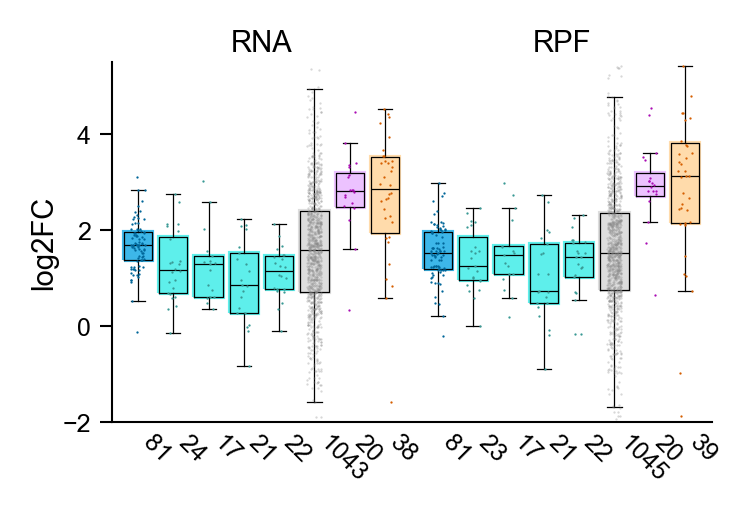

<Figure size 640x480 with 0 Axes>

In [12]:
sF = 1 # Size factor
wgap = 0.1
hgap = 0.1
nrow, ncol = 1, 1

width_ratios = [2]
height_ratios = [1.2]

fs_w = sum(np.array(width_ratios)*sF) + (ncol-1)*wgap*sF
fs_h = sum(np.array(height_ratios)*sF) + (nrow-1)*hgap*sF

#
fig = plt.figure(figsize=( fs_w, fs_h ), dpi=300)
grid = plt.GridSpec(nrow, ncol,
                    width_ratios=width_ratios,
                    height_ratios=height_ratios,
                    wspace=wgap/np.average(width_ratios), 
                    hspace=hgap/np.average(height_ratios),
                    left=0, right=1, bottom=0, top=1)


ax = fig.add_subplot(grid[0,0])

box = ax.boxplot(plot_data, positions=x_pos, 
                 widths=0.8,
                 medianprops={'linewidth':0.3, 'color':'k'},
                 boxprops={'linewidth':0.3, 'color':'k'},
                 whiskerprops={'linewidth':0.3, 'color':'k'},
                 capprops={'linewidth':0.3, 'color':'k'},
                 showfliers=False,
                #  showmeans=True, meanprops={'marker':'D', 'markersize':'1.5', 'markerfacecolor':'k', 'markeredgewidth':0}
                 )
for artist, color in zip(box['boxes'], box_color_list):
    patch = mpl.patches.PathPatch(artist.get_path(), color=color)
    ax.add_artist(patch)

for x, values, c in zip(x_pos, plot_data, sct_color_list):
    rasterized = False
    if x == 5: rasterized = True
    if x == 13.5: rasterized = True
    strip_plot(x=x, y=values, 
               width=0.4, s=0.3, c=c, lw=0, 
               ax=ax, rasterized=rasterized)

for xp, lib in zip([np.average([x_pos[3],x_pos[4]]), np.average([x_pos[11],x_pos[12]])],['RNA','RPF']):
    ax.text(xp, 5.6, lib, ha='center', va='bottom', fontsize=7)

ax.set_xlim(x_pos[0]-0.5-group_gap/2, x_pos[-1]+0.5+group_gap/2)
ax.set_ylim(-2,5.5)
# ax.set_xticks([])
# ax.set_xticklabels([GS for GS in Genesets]*3, ha='left', rotation=-75)
ax.set_xticklabels([len(l) for l in plot_data], ha='left', rotation=-45)
ax.tick_params(width=0.5, length=3, pad=2)
ax.tick_params(axis='x', length=0, pad=2)

ax.set_xlabel('')
ax.set_ylabel('log2FC', labelpad=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)


plt.savefig('mitoTranslation_R-P-logFC_box.pdf', bbox_inches='tight')
plt.show()
plt.clf()

In [9]:
from scipy.stats import mannwhitneyu, ks_2samp

print(mannwhitneyu(plot_data[0], plot_data[5]))
print(mannwhitneyu(plot_data[1], plot_data[5]))
print(mannwhitneyu(plot_data[2], plot_data[5]))
print(mannwhitneyu(plot_data[3], plot_data[5]))
print(mannwhitneyu(plot_data[4], plot_data[5]), '\n')
print(mannwhitneyu(plot_data[6], plot_data[5]))
print(mannwhitneyu(plot_data[7], plot_data[5]), '\n')

print(mannwhitneyu(plot_data[8], plot_data[13]))
print(mannwhitneyu(plot_data[9], plot_data[13]))
print(mannwhitneyu(plot_data[10], plot_data[13]))
print(mannwhitneyu(plot_data[11], plot_data[13]))
print(mannwhitneyu(plot_data[12], plot_data[13]), '\n')
print(mannwhitneyu(plot_data[14], plot_data[13]))
print(mannwhitneyu(plot_data[15], plot_data[13]), '\n')

MannwhitneyuResult(statistic=45161.5, pvalue=0.2995583712226767)
MannwhitneyuResult(statistic=10283.0, pvalue=0.1347280601790867)
MannwhitneyuResult(statistic=7160.5, pvalue=0.1734095007062212)
MannwhitneyuResult(statistic=7431.5, pvalue=0.011592120025456683)
MannwhitneyuResult(statistic=8505.0, pvalue=0.03766366179172203) 

MannwhitneyuResult(statistic=15705.0, pvalue=0.00010517901190450965)
MannwhitneyuResult(statistic=28820.0, pvalue=1.915085472704348e-06) 

MannwhitneyuResult(statistic=42242.5, pvalue=0.9775054282069063)
MannwhitneyuResult(statistic=10777.5, pvalue=0.3969485372536864)
MannwhitneyuResult(statistic=8554.5, pvalue=0.7940405016225983)
MannwhitneyuResult(statistic=7904.5, pvalue=0.02809452073039041)
MannwhitneyuResult(statistic=10056.0, pvalue=0.3145855865358639) 

MannwhitneyuResult(statistic=16244.0, pvalue=2.119935346214486e-05)
MannwhitneyuResult(statistic=30972.5, pvalue=3.408006965498865e-08) 

